In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot
from sklearn.decomposition import PCA
import tqdm

from ae_downloader import Downloader

def visnorm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [118]:
downloader = Downloader(tile_size=512)

In [119]:
year = 2020
locations = {"san_francisco": (37.7749, -122.4194),
             "new_york": (40.7128, -74.0060),
             "los_angeles": (34.0522, -118.2437),
             "bregenz": (47.50489881092864, 9.725558000922499),
            }

In [120]:
for location_id, (lat, lon) in tqdm.tqdm(locations.items()):
    downloader.download(lat, lon, year, location_id)

  0%|                                                                                                                             | 0/4 [00:00<?, ?it/s]INFO:ae_downloader_light:Processing san_francisco.
INFO:ae_downloader_light:Found target file s3://us-west-2.opendata.source.coop/tge-labs/aef/v1/annual/2020/10N/xo0b8wamdvpz9vcrm-0000008192-0000000000.tiff.
INFO:ae_downloader_light:Reading file...
INFO:ae_downloader_light:Saving data...
INFO:ae_downloader_light:Saved data to ./ae_embeddings/2020/san_francisco.tiff.
INFO:ae_downloader_light:Finished obtaining data for san_francisco.
 25%|█████████████████████████████▎                                                                                       | 1/4 [00:39<01:57, 39.20s/it]INFO:ae_downloader_light:Processing new_york.
INFO:ae_downloader_light:Found target file s3://us-west-2.opendata.source.coop/tge-labs/aef/v1/annual/2020/18N/xizquait4xihepxqq-0000008192-0000008192.tiff.
INFO:ae_downloader_light:Reading file...
INFO:ae_downloa

In [123]:
files = glob.glob(f"ae_embeddings/{year}/*.tiff")
location_ids = [f.split("/")[-1].replace(".tiff", "") for f in files]

embeddings = []
profiles = []
for f in files:
    with rasterio.open(f) as ds:
        embeddings.append(ds.read())
        profiles.append(ds.profile)

h, w = embeddings[0].shape[1:]

pca = PCA(n_components=3)
valid = [not bool(np.isnan(e).any()) for e in embeddings]
files = [f for f,v in zip(files, valid) if v]
embeddings = [e for e,v in zip(embeddings, valid) if v]

embeddings_pca = [pca.fit_transform(np.moveaxis(e, 0, -1).reshape(-1, 64)) for e in embeddings]
embeddings_pca = [e.reshape((h, w, 3)) for e in embeddings_pca]

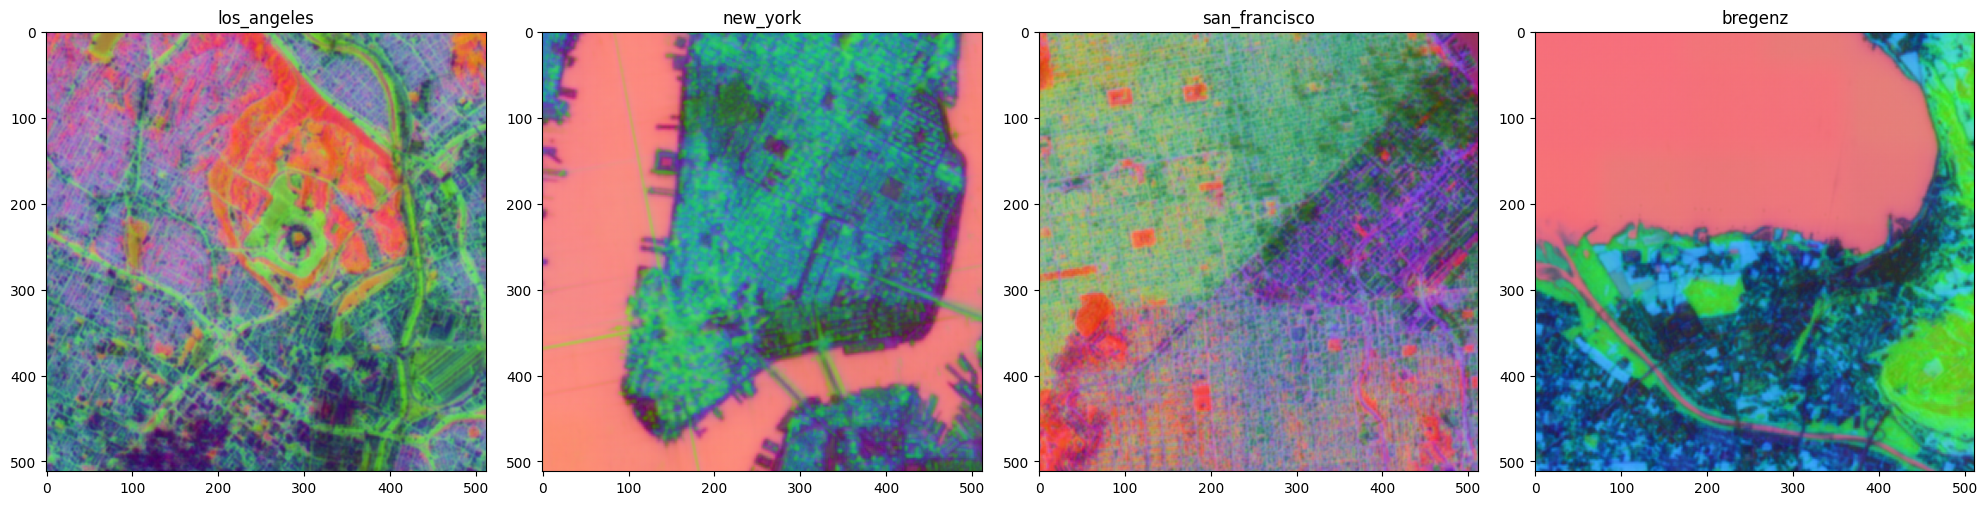

In [125]:
fig, axs = plt.subplots(1, len(files), figsize=(5*len(files), 5))
for idx in range(len(files)):
    if len(files) > 1:
        ax = axs[idx]
    else:
        ax = axs
    
    ax.imshow(visnorm(embeddings_pca[idx]))
    ax.set_title(location_ids[idx])

plt.tight_layout()
plt.show()